In [1]:
!pip install -U langchain_community tiktoken langchain-groq langchainhub chromadb langchain langgraph langchain_huggingface

  Obtaining dependency information for langchain_community from https://files.pythonhosted.org/packages/22/dc/6cde0b7179868fc6eafe458b39276051798b979d55d5a8ca7b45dae89558/langchain_community-0.2.11-py3-none-any.whl.metadata
  Obtaining dependency information for tiktoken from https://files.pythonhosted.org/packages/bf/4b/48ca098cb580c099b5058bf62c4cb5e90ca6130fa43ef4df27088536245b/tiktoken-0.7.0-cp312-cp312-win_amd64.whl.metadata
  Using cached tiktoken-0.7.0-cp312-cp312-win_amd64.whl.metadata (6.8 kB)
  Obtaining dependency information for langchain-groq from https://files.pythonhosted.org/packages/61/58/01bdd52b216e472da749b1d7c6fcc5f0b2b2d3d7ac8a111f71351a587d31/langchain_groq-0.1.9-py3-none-any.whl.metadata
  Obtaining dependency information for langchainhub from https://files.pythonhosted.org/packages/63/af/1ede340c6283f6a70cf0e2aaa4e9c8e817ff54b0ec4df4fd956d81abffea/langchainhub-0.1.20-py3-none-any.whl.metadata
  Obtaining dependency information for chromadb from https://files.py


[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
LANGCHAIN_API_KEY="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"
LANGCHAIN_TRACING_V2="true"
LANGCHAIN_PROJECT="LiveLangGraph"


In [6]:
from langchain_groq import ChatGroq
groq_api_key="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"

In [7]:
llm=ChatGroq(api_key=groq_api_key,model_name="Gemma2-9b-It")

In [ ]:
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

from typing import Annotated
from typing_extensions import TypedDict


In [ ]:
class State(TypedDict):
    messages:Annotated[list,add_messages]
    

In [2]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

d:\Genai_repos\Rag\rag_env\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [3]:

### Build Index

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma


USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorstore
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)
retriever = vectorstore.as_retriever()

ModuleNotFoundError: No module named 'bs4'

In [ ]:
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field



# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "wiki_search"] = Field(
        ...,
        description="Given a user question choose to route it to wikipedia or a vectorstore.",
    )

from google.colab import userdata
# LLM with function call
from langchain_groq import ChatGroq
import os
groq_api_key=userdata.get('groq_api_key')
os.environ["GROQ_API_KEY"]=groq_api_key
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": "who is Sharukh Khan?"}
    )
)
print(question_router.invoke({"question": "What are the types of agent memory?"}))

datasource='wiki_search'
datasource='vectorstore'


In [ ]:
### Retrieval Grader


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

    # Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [ ]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")
print(prompt)
# LLM
#llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

input_variables=['context', 'question'] metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))]
Agent memory is crucial for LLM-powered agents to retain and recall information over time.  

It consists of short-term memory, which utilizes in-context learning, and long-term memory, often implemented using an external vector store for efficient retrieval. 



In [ ]:
### Hallucination Grader


# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

In [ ]:
### Answer Grader


# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
#llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

In [ ]:
!pip install langchain_community
!pip install arxiv wikipedia

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.2 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11680 sha256=5ef675d6e01881cdd38b647e781556d555bb0b84752879b91a8e6ae5b507ebd9
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=1187ab56682be06335fc49ee89746b67f5d58e47b0ee4923cca8becc15eb3c39
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built wikipedia sgmllib3k
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver do

In [ ]:
# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate only one improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'What are the capabilities and limitations of agent memory? \n'

In [ ]:
### Working With Tools
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv and wikipedia Tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [ ]:
wiki.invoke("What is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and gen'

In [ ]:
## Graph

from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [ ]:
wiki.invoke({"query": "What is machine learning"})

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and gen'

In [ ]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}





def wiki_search(state):
    """
    wiki search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---wikipedia---")
    print("---HELLO--")
    question = state["question"]
    print(question)

    # Wiki search
    docs = wiki.invoke({"query": question})
    #print(docs["summary"])
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {"documents": wiki_results, "question": question}


### Edges ###


def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [ ]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("wiki_search", wiki_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("wiki_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

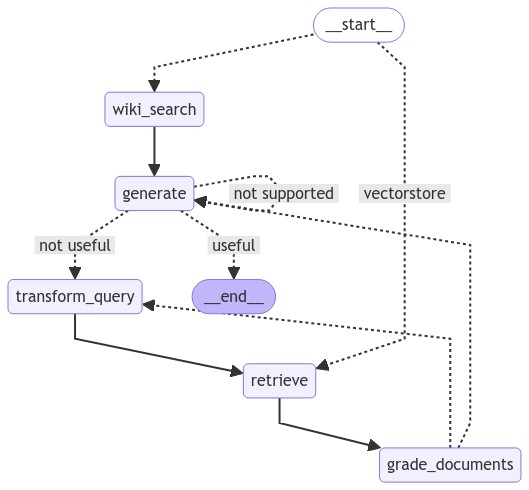

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
app

CompiledStateGraph(nodes={'__start__': PregelNode(config={'tags': ['langsmith:hidden'], 'metadata': {}, 'configurable': {}}, channels=['__start__'], triggers=['__start__'], writers=[ChannelWrite<question,generation,documents>(recurse=True, writes=[ChannelWriteEntry(channel='question', value=<object object at 0x7b2ab705b0e0>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='generation', value=<object object at 0x7b2ab705b0e0>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='documents', value=<object object at 0x7b2ab705b0e0>, skip_none=False, mapper=_get_state_key(recurse=False))], require_at_least_one_of=['question', 'generation', 'documents']), _route(recurse=True, _is_channel_writer=True)]), 'wiki_search': PregelNode(config={'tags': [], 'metadata': {}, 'configurable': {}}, channels={'question': 'question', 'generation': 'generation', 'documents': 'documents'}, triggers=['branch:__start__:route_question:wiki_search']

In [ ]:
from pprint import pprint

# Run
inputs = {
    "question": "Tell me about Sharukh Khan?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO Wiki SEARCH---
---wikipedia---
---HELLO--
Tell me about Sharukh Khan?
"Node 'wiki_search':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Shah Rukh Khan, also known as SRK, is an Indian actor and film producer.  He '
 'is known for his work in Hindi cinema.  Khan was born on November 2, '
 '1965.  \n')


In [ ]:
# Run
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('The text describes two types of agent memory: a memory stream and a '
 'retrieval model.  The memory stream is a long-term memory module that '
 'records agent experiences in natural language. The retrieval model surfaces '
 'context to inform agent behavior based on relevance, recency, and '
 'importance. \n')
